In [1]:
# imports

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

- works well for straight lines
- for curve lines, should try clip the rectangle area

In [ ]:
# calibrate camera
# only run once

import glob

# read images
images = glob.glob('camera_cal/calibration*.jpg')

objpoints = []
imgpoints = []
nx = 9
ny = 6

# prepare object points
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

for idx, fname in enumerate(images):
    plt.figure(idx+1)
    print("finding corners for image..", fname)
    # read image
    img = mpimg.imread(fname)
    
    # display original image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # find corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    print("can draw corners:", ret)
    
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.subplot(1, 2, 2)
        plt.imshow(img)

    plt.show()

print("start calibration camera")
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
print("show calibrated camera")

for idx, fname in enumerate(images):
    img = mpimg.imread(fname)
    print("undistorting image...", fname)
    plt.figure(idx+1)
    plt.subplot(1,2,1)
    plt.title("original")
    plt.imshow(img)

    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    plt.subplot(1,2,2)
    plt.title("undistorted")
    plt.imshow(undistorted)
    plt.show()


In [ ]:
# save calibrated result: mtx, dist
import pickle

with open('calibration.pickle', 'wb') as f:  
    pickle.dump([mtx,dist], f)



In [2]:
import pickle
# Getting back the objects:
with open('calibration.pickle', 'rb') as f:  # Python 3: open(..., 'rb')
    mtx,dist = pickle.load(f)


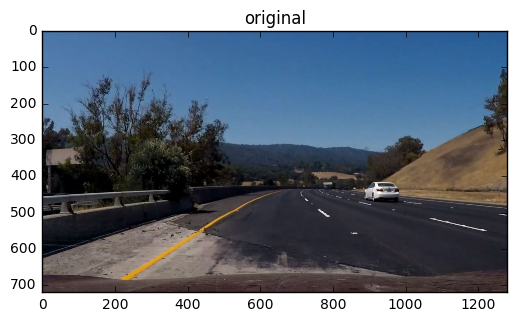

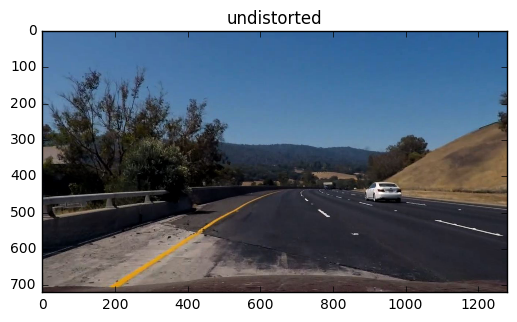

In [23]:
# test images
%matplotlib inline
fname = 'input_sequence/problem_input 041.jpg'
img = mpimg.imread(fname)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

plt.figure(1)
plt.title('original')
plt.imshow(img)

plt.figure(2)
plt.title('undistorted')
plt.imshow(undistorted)

plt.show()

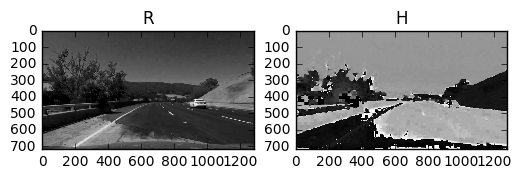

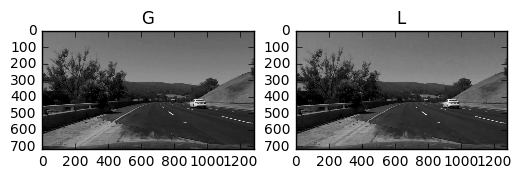

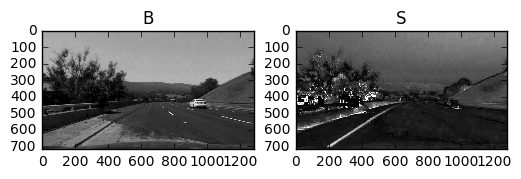

In [24]:
# color transform and gradients
%matplotlib inline
# visualize RGB and HLS
hls = cv2.cvtColor(undistorted, cv2.COLOR_RGB2HLS)

R = undistorted[:,:,0]
G = undistorted[:,:,1]
B = undistorted[:,:,2]

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

plt.figure(1)
plt.subplot(1,2,1)
plt.imshow(R,cmap='gray')
plt.title('R')
plt.subplot(1,2,2)
plt.imshow(H,cmap='gray')
plt.title('H')

plt.figure(2)
plt.subplot(1,2,1)
plt.imshow(G,cmap='gray')
plt.title('G')
plt.subplot(1,2,2)
plt.imshow(L,cmap='gray')
plt.title('L')

plt.figure(3)
plt.subplot(1,2,1)
plt.imshow(B,cmap='gray')
plt.title('B')
plt.subplot(1,2,2)
plt.imshow(S,cmap='gray')
plt.title('S')

plt.show()

In [ ]:
np.max(R)

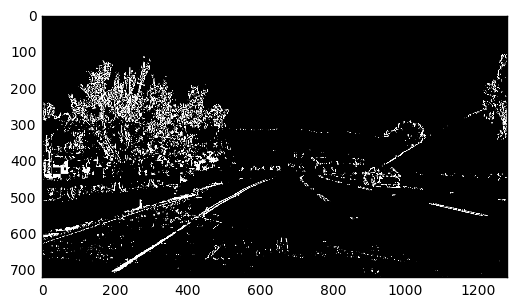

In [28]:
# try S + sobel x
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(S)
s_binary[(S >= s_thresh_min) & (S <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

plt.imshow(combined_binary, cmap='gray')

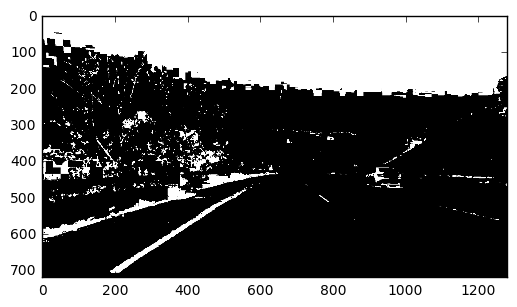

In [27]:
%matplotlib inline
# red: white; blue: dark; saturation: white

#R: red
r_thresh = (200, 255)
r_binary = np.zeros_like(R)
r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1

#S: white
s_thresh = (90, 255)
s_binary = np.zeros_like(S)
s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1

# stack R and S
combined_binary = np.zeros_like(S)
combined_binary[((s_binary == 1) | (r_binary == 1))] = 1

plt.imshow(combined_binary,cmap='gray')


In [29]:
s_binary = combined_binary

In [20]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

(720, 1280, 3)


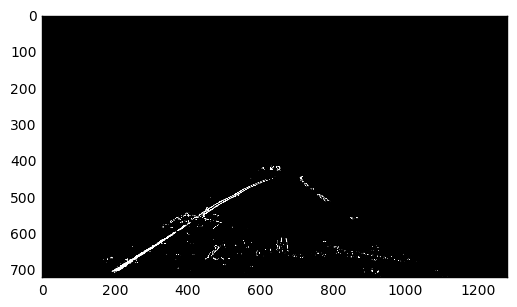

In [30]:
buffer_bucket = 15
%matplotlib inline

print(img.shape)
xsize,ysize = img.shape[1],img.shape[0]

x_buffer    = xsize / buffer_bucket

lower_left  = (x_buffer,       ysize)
lower_right = (xsize-x_buffer, ysize)
top_left    = (xsize/2-10,     ysize/2+45) # normally the horizon is towards the bottom half
top_right   = (xsize/2+10,     ysize/2+45)

vertices = np.array([[
            lower_left,
            top_left,
            top_right,
            lower_right
        ]], dtype=np.int32)

region = region_of_interest(s_binary, vertices)


plt.imshow(region,cmap='gray')

In [31]:
s_binary = region

In [ ]:
# perspective tranform, note, this is from straight_lines1.jpg
# only run once
src = np.float32(
    [
        [765,504], #top right
        [1060,700], #bottom right
        [240,700], #bottom left
        [525,500], #top left
    ]
)

dst = np.float32(
    [
        [800,450],
        [800,700],
        [200,700],
        [200,450]
    ]
)

M = cv2.getPerspectiveTransform(src,dst)


In [ ]:
Minv = cv2.getPerspectiveTransform(dst, src)

In [ ]:
# save perspective transform

with open('perspective.pickle', 'wb') as f:  
    pickle.dump([M,Minv], f)


In [32]:
# load perspective transform
with open('perspective.pickle', 'rb') as f:
    M,Minv = pickle.load(f)

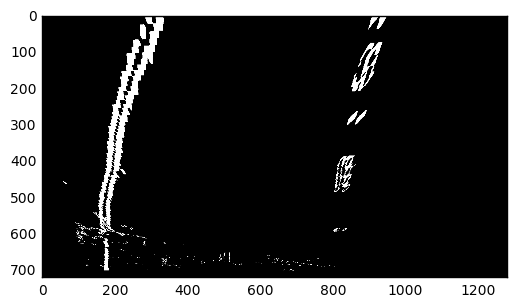

In [33]:
img_size = (s_binary.shape[1], s_binary.shape[0])

warped = cv2.warpPerspective(s_binary, M, img_size, flags=cv2.INTER_LINEAR)

%matplotlib inline
plt.imshow(warped, cmap='gray')

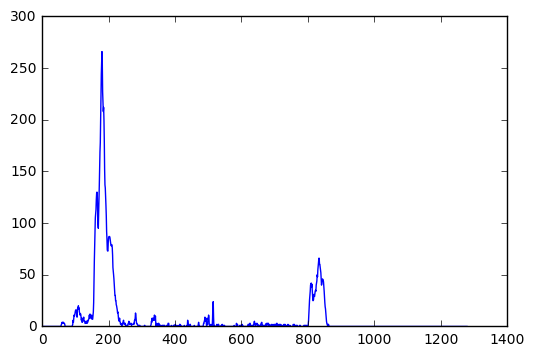

In [34]:
# plot histogram
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

In [35]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

window_size = 100

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_size
    win_y_high = warped.shape[0] - window*window_size
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [36]:
print("leftx count: ", len(leftx))
print("rightx count: ", len(rightx))
max(righty)-min(righty)
max(lefty)-min(lefty)
print(left_fit)
print(right_fit)

leftx count:  23222
rightx count:  7131
[  3.67389481e-04  -4.63528570e-01   3.17080943e+02]
[  1.27553435e-04  -2.83665125e-01   9.28928741e+02]


In [37]:
# measuring curvature
def get_curvature(leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    y_eval_left = np.max(lefty)
    y_eval_right = np.max(righty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')

In [38]:
get_curvature(leftx, lefty, rightx, righty)

447.038553136 m 1287.87329141 m


(720, 0)

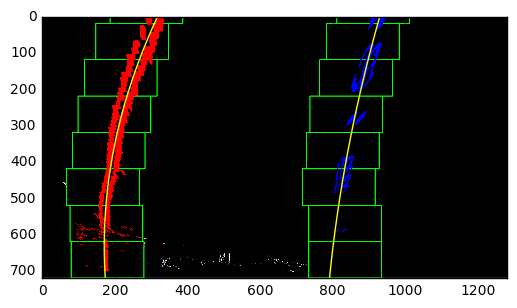

In [39]:
# Generate x and y values for plotting
fity = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
fit_leftx = left_fit[0]*fity**2 + left_fit[1]*fity + left_fit[2]
fit_rightx = right_fit[0]*fity**2 + right_fit[1]*fity + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(fit_leftx, fity, color='yellow')
plt.plot(fit_rightx, fity, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

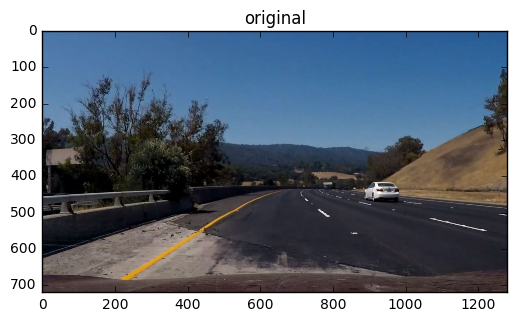

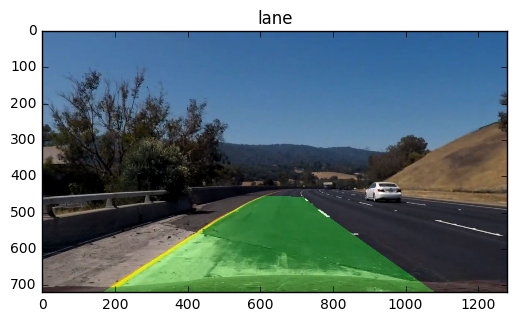

In [40]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([fit_leftx, fity]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_rightx, fity])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

plt.figure(1)
plt.title('original')
plt.imshow(img)

plt.figure(2)
plt.title('lane')
plt.imshow(result)

plt.show()